# Correspondence Analysis 

Functions to make Correspondence Analysis from scratch

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.DataFrame({
                  'education': ['Some primary', 'Primary completed', 
                            'Some secondary','Secondary completed',
                            'Some tertiary'],
                  'Glance': [5,18,19, 12, 3],
                  'Fairly thorough': [7,46,29,40,7],
                  'Very thorough': [2,20,39,49,16]})
df = df.set_index('education')
df

,Glance,Fairly thorough,Very thorough
education,,,
Some primary,5,7,2
Primary completed,18,46,20
Some secondary,19,29,39
Secondary completed,12,40,49
Some tertiary,3,7,16


# Detailed steps

## Step 1: compute observed proportion

In [3]:
P = np.array(df / df.values.sum())
P

array([[0.01602564, 0.0224359 , 0.00641026],
       [0.05769231, 0.1474359 , 0.06410256],
       [0.06089744, 0.09294872, 0.125     ],
       [0.03846154, 0.12820513, 0.15705128],
       [0.00961538, 0.0224359 , 0.05128205]])

## Step 2: computes masses

In [4]:
column_masses = P.sum(axis=0)
row_masses = P.sum(axis=1)
row_masses

array([0.04487179, 0.26923077, 0.27884615, 0.32371795, 0.08333333])

## Step 3: compute Expected proportion

a table is created by multiplying each of the row totals (row masses) by each of the column totals.

In [5]:
E = np.outer(row_masses, column_masses)
E

array([[0.00819773, 0.01855276, 0.0181213 ],
       [0.04918639, 0.11131657, 0.10872781],
       [0.05094305, 0.11529216, 0.11261095],
       [0.05914078, 0.13384492, 0.13073225],
       [0.01522436, 0.03445513, 0.03365385]])

## Step 4 Compute Residuals

We compute the residuals by subtracting the expected proportions from the observed proportions. Residuals in correspondence analysis have a different role to that which is typical in statistics. Typically in statistics, the residuals quantify the extent of error in a model. In correspondence analysis, by contrast, the whole focus is on examining the residuals.

The residuals quantify the difference between the observed data and the data we would expect under the assumption that there is no relationship between the row and column categories of the table (i.e., education and readership, in our example).

In [6]:
R = P - E
R

array([[ 0.00782791,  0.00388314, -0.01171105],
       [ 0.00850592,  0.03611933, -0.04462525],
       [ 0.00995439, -0.02234344,  0.01238905],
       [-0.02067924, -0.00563979,  0.02631903],
       [-0.00560897, -0.01201923,  0.01762821]])

The biggest residual is -0.045 for Primary completed and Very thorough. That is, the observed proportion of people that only completed primary school and are very thorough is 6.4%, and this is 4.5% lower than the expected proportion of 10.9%, which is computed under the assumption of no relationship between newspaper readership and education. Thus, the tentative conclusion that we can draw from this is that there is a negative association between having completed primary education and reading very thoroughly. That is, people with only primary school education are less likely to read very thoroughly than the average person.

## Step 5 Indexed Residuals

Take a look at the top row of the residuals shown in the table above. All of the numbers are close to 0. The obvious explanation for this – that having some primary education is unrelated to reading behavior –  is not correct. The real explanation is all the observed proportions (P) and the expected proportions (E) are small because only 4.6% of the sample had this level of education. This highlights a problem with looking at residuals from a table. By ignoring the number of people in each of the rows and columns, we end up being most likely to find results only in rows and columns with larger totals (masses). We can solve this problem by dividing the residuals by the expected values, which gives us a table of indexed residuals (I)

In [7]:
I = R / E
I

array([[ 0.95488722,  0.20930233, -0.6462585 ],
       [ 0.17293233,  0.32447398, -0.41043084],
       [ 0.1954023 , -0.19379845,  0.11001642],
       [-0.34966128, -0.04213677,  0.20132013],
       [-0.36842105, -0.34883721,  0.52380952]])

The indexed residuals have a straightforward interpretation. The further the value from the table, the larger the observed proportion relative to the expected proportion. We can now see a clear pattern. The biggest value on the table is the .95 for Some primary and Glance. This tells us that people with some primary education are almost twice as likely to Glance at a newspaper as we would expect if there were no relationship between education and reading. In other words, the observed value is 95% higher than the expected value. Reading along this first row, we see that there is a weaker, but positive, indexed residual of 0.21 for Fairly thorough and Some primary. This tells us that people with some primary education were 21% more likely to be fairly thorough readers that we would expect. And, a score of -.65 for Very thorough, tells us that people with Some primary education were 65% less likely to be Very thorough readers than expected. Reading through all the numbers on the table, the overall pattern is that higher levels of education equate to a more thorough readership.

As we will see later, correspondence analysis is a technique designed for visualizing these indexed values.

## Step 6: Reconstituting indexed residuals from a map

### Singular Value Decomposition (SVD)

The first line computes Z, by multiplying together each of indexed residuals by the square root of their corresponding expected values

First, Z is a standardized residual,

Second, and more importantly from the perspective of correspondence analysis, what this does is cause the singular value decomposition to be weighted, such that cells with a higher expected value are given a higher weight in the data

As often the expected values are related to the sample size, this weighting means that smaller cells on the table, for which the sampling error will be larger, are down-weighted

 In other words, this weighting makes correspondence analysis relatively robust to outliers caused by sampling error, when the table being analyzed is a contingency table.

In [8]:
Z = I * np.sqrt(E)
Z

array([[ 0.08645676,  0.02850876, -0.08699634],
       [ 0.03835294,  0.10825794, -0.13533506],
       [ 0.04410341, -0.06580368,  0.03691882],
       [-0.0850337 , -0.01541566,  0.07279115],
       [-0.04545838, -0.06475149,  0.09609278]])

A singular value decomposition has three outputs:

A vector, d, contains the singular values.
A matrix u which contains the left singular vectors.
A matrix v with the right singular vectors.

The left singular vectors correspond to the categories in the rows of the table and the right singular vectors correspond to the columns. Each of the singular values, and the corresponding vectors (i.e., columns of u and v), correspond to a dimension. As we will see, the coordinates used to plot row and column categories are derived from the first two dimensions

In [9]:
u, d, v  = np.linalg.svd(Z, full_matrices=False)
v = v.T
v

array([[-0.40977945, -0.80584644, -0.42742521],
       [-0.48877954,  0.58960413, -0.64300975],
       [ 0.77017879, -0.05457549, -0.63548891]])

### Eigenvalues

$$d^2$$

Each of these eigenvalues is proportional to the amount of variance explained by the columns.

In [10]:
eigenvalues = np.power(d, 2)
eigenvalues

array([7.03685908e-02, 1.28917983e-02, 1.47285895e-32])

By summing them up and expressing them as a proportion, we compute that the first dimension of our correspondence analysis explains 84.5% of the variance in the data and the second 15.5%, which are the numbers shown in x and y labels of the scatter plot shown earlier. 

In [11]:
variance_explained = eigenvalues / eigenvalues.sum()
variance_explained

array([8.45162886e-01, 1.54837114e-01, 1.76897918e-31])

## Step 7:Standard coordinate

As mentioned, we have weighted the indexed residuals prior to performing the SVD. So, in order to get coordinates that represent the indexed residuals we now need to unweight the SVD’s outputs. We do this by dividing each row of the left singular vectors by the square root of the row masse

### Rows

In [0]:
size = len(row_masses)
row_masses_t = row_masses.reshape((size,1))
std_rows_coordinate = np.divide(u, np.sqrt(row_masses_t))

### Columns

In [13]:
size = len(column_masses)
column_masses_t = column_masses.reshape((size,1))
std_columns_coordinate = np.divide(v, np.sqrt(column_masses_t))
std_columns_coordinate

array([[-0.95871616, -1.88535077, -1.        ],
       [-0.76014328,  0.9169443 , -1.        ],
       [ 1.21194686, -0.08587953, -1.        ]])

## Step 8:  Map the coordinate

### Principal coordinates

The principal coordinates are the standard coordinates multiplied by the corresponding singular values

The principal coordinates for the education levels (rows) are shown in the table below.


In [0]:
principal_coordinate_rows = std_rows_coordinate * d
principal_coordinate_columns = std_columns_coordinate * d

In [15]:
principal_coordinate_rows

array([[-5.49335002e-01, -2.27135915e-01, -1.39983435e-16],
       [-3.33149339e-01,  7.76849206e-02, -1.25622162e-16],
       [ 8.05306357e-02, -1.44592892e-01, -1.07771931e-16],
       [ 1.73020505e-01,  9.74798593e-02, -1.10250522e-16],
       [ 4.30538395e-01, -2.35197958e-02, -1.70657928e-16]])

In [16]:

df_coordinate_r = pd.DataFrame(principal_coordinate_rows[:, :-1],
                            columns = ['dim_1', 'dim_2'],
                            index = df.index)
#df_coordinate_r['dim_2'] = df_coordinate_r['dim_2'].astype('float')
df_coordinate_r.dtypes

dim_1    float64
dim_2    float64
dtype: object

In [17]:
df_coordinate_c = pd.DataFrame(std_columns_coordinate[:, :-1],
                            columns = ['dim_1', 'dim_2'],
                            index = list(df))
df_coordinate_c

,dim_1,dim_2
Glance,-0.958716,-1.885351
Fairly thorough,-0.760143,0.916944
Very thorough,1.211947,-0.085880


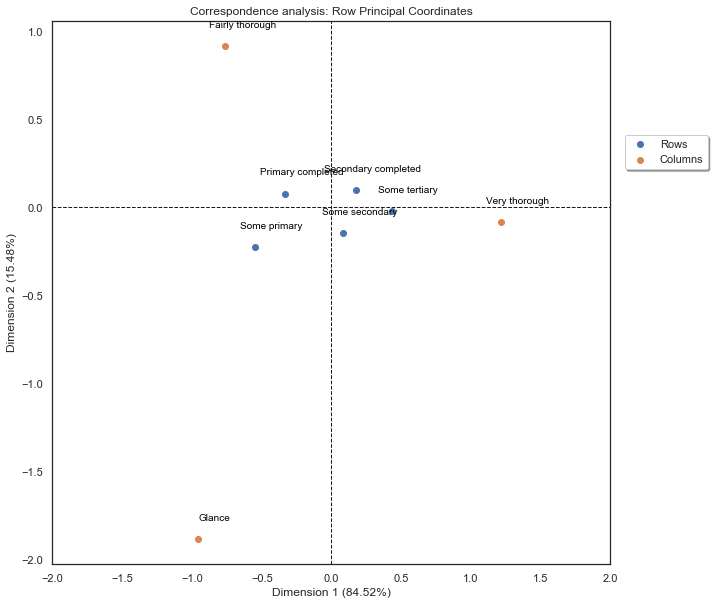

In [117]:
dic_df = {
    'rows': [df_coordinate_r.index, df_coordinate_r['dim_1'],
            df_coordinate_r['dim_2']],
    'columns': [df_coordinate_c.index, df_coordinate_c['dim_1'],
            df_coordinate_c['dim_2']]
}


sns.set(style="white")
fig, ax = plt.subplots(figsize=(10, 10))

####Upper
#ax = axs[0]
ax.scatter(df_coordinate_r['dim_1'],
           df_coordinate_r['dim_2'], label='Rows')
ax.scatter(df_coordinate_c['dim_1'],
           df_coordinate_c['dim_2'], label='Columns')

for x, name in dic_df.items():
  for i, label in enumerate(name[0]):
     ax.text(name[1][i]+0.12,
             name[2][i]+0.12,
             label,
             color='black',
             ha='center',
             va='center',
             fontsize=10)
ax.set_xlim(-2, 2)  
ax.axhline(y=0, color='k', linewidth=1, linestyle = "--")
ax.axvline(x=0, color='k', linewidth=1, linestyle = "--")   
ax.set_xlim(-2, 2)  
ax.legend(loc='upper center', bbox_to_anchor=(1.1, 0.8), shadow=True, ncol=1)
plt.title('Correspondence analysis: Row Principal Coordinates')

# Add the axis labels
plt.xlabel('Dimension 1 (%.2f%%)' % (variance_explained[0]*100))
plt.ylabel('Dimension 2 (%.2f%%)' % (variance_explained[1]*100))
plt.show()

The second part to interpretation, which will likely bring you back to high school, is the meaning of the cosine. If two points are in exactly the same direction from the origin (i.e., they are on the same line), the cosine of the angle is 1. The bigger the angle, the smaller the cosine, until we get to a right-angle (90° or 270°), at which point the cosine is 0. And, when the lines are going in exactly opposite directions (i.e., so the line between the two points goes through the origin), the cosine of the angle is -1. So, when you have a small angle from the lines connecting the points to the origin, the association is relatively strong (i.e., a positive indexed residual). When there is a right angle there is no association (i.e., no residual). When there is a wide angle, a negative residual is an outcome.

- People with only Primary completed are relatively unlikely to be Very thorough.
- Those with Some primary are more likely to Glance.
- People with Primary completed are more likely to be Fairly thorough.
- The more education somebody has, the more likely they are to be Very thorough.

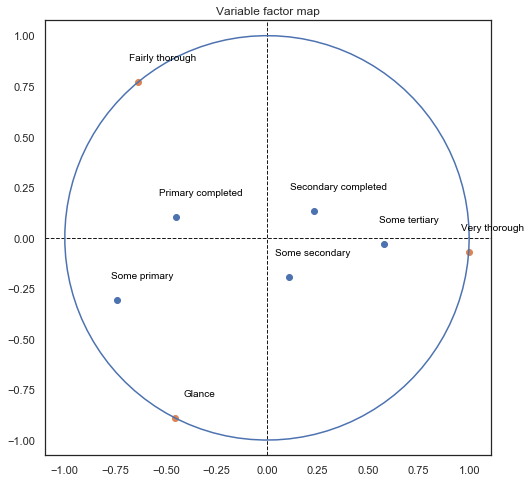

In [106]:
col_norm = normalize(df_coordinate_c['dim_1'], df_coordinate_c['dim_2'])
row_norm = normalize(df_coordinate_r['dim_1'],
          df_coordinate_r['dim_2'],
          scaler = 0.8,
          option  = 'row')

dic_df_rescale = {

    'rows_rescale': [row_norm.index, row_norm['x_shrink'],
            row_norm['y_shrink']],
    'columns_rescale': [col_norm.index, col_norm['x_shrink'],
            col_norm['y_shrink']]
}
fig, ax = plt.subplots(figsize=(8, 8))

an = np.linspace(0, 2 * np.pi, 100)


ax.scatter(row_norm['x_shrink'],
           row_norm['y_shrink'])
ax.scatter(col_norm['x_shrink'],
           col_norm['y_shrink'])

for i, name in dic_df_rescale.items():
  for i, label in enumerate(name[0]):
     ax.text(name[1][i]+0.12,
             name[2][i]+0.12,
             label,
             color='black',
             ha='center',
             va='center',
             fontsize=10)
ax.axhline(y=0, color='k', linewidth=1, linestyle = "--")
ax.axvline(x=0, color='k', linewidth=1, linestyle = "--")
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
ax.set_title('Variable factor map')
plt.show()

#  Wrap everything together

## function dimensions

In [0]:
def correspondance_analysis(df):
  """
  Compute dimensions 1 and 2 for 
  - rows
  - columns
  
  The normalization is only applied to rows 
  return
  pc_rows: dim 1 & 2 for rows
  pc_column: dim 1 & 2 for columns
  variance explained
  eigenvalues
  """
  
  ### Step 1: Compute observed proportion
  P = np.array(df / df.values.sum())

  ### Step 2: computes masses
  column_masses = P.sum(axis=0)
  row_masses = P.sum(axis=1)
  E = np.outer(row_masses, column_masses)
  ### Step 3: Compute residuals
  R = P - E

  ### Step 4: Compute indexed Residuals
  I = R / E

  ### Step 5: Reconstituting endexed residual
  Z = I * np.sqrt(E)

  #### SVD
  u, d, v  = np.linalg.svd(Z, full_matrices=False)
  v = v.T

  #### Eigen value
  eigenvalues = np.power(d, 2)

  #### Compute variance explained
  variance_explained = eigenvalues / eigenvalues.sum()

  ### Step 7: Standard coordinate
  #### Only rows normaization for now

  ##### Rows
  size = len(row_masses)
  row_masses_t = row_masses.reshape((size,1))
  std_rows_coordinate = np.divide(u, np.sqrt(row_masses_t))

  ##### Columns
  size = len(column_masses)
  column_masses_t = column_masses.reshape((size,1))
  std_columns_coordinate = np.divide(v, np.sqrt(column_masses_t))
  principal_coordinate_rows = std_rows_coordinate * d
  principal_coordinate_columns = std_columns_coordinate * d

  ##### To DF
  df_coordinate_r = pd.DataFrame(principal_coordinate_rows[:, :-1],
                            columns = ['dim_1', 'dim_2'],
                            index = df.index)

  df_coordinate_c = pd.DataFrame(std_columns_coordinate[:, :-1],
                            columns = ['dim_1', 'dim_2'],
                            index = list(df))

  dic_results = {
	'pc_rows': df_coordinate_r,
	'pc_columns': df_coordinate_c,
	'variance_explained': variance_explained,
	'eigenvalues': eigenvalues
  }

  return dic_results

## Make graphs

In [0]:
def normalize(x, y, scaler = 0.8, option = 'column'):
  """
  objective:  Get the coordinates on the cirle line
  Euclidean distance is square root of sum of x square 
  and y square
  We know that the euclidean distance should be equal to 
  the radius (ie 1) to be exactly on the circle
  therefore, we need to find alpha to shrink our vector
  
  For the column, rescale is alpha * distance
  for the row, need to rescale to fit the circle
  take the minimum alpha (ie largest distance) and apply a 
  scaler. If scaler is 1, the largest row's distance will
  be on the circle line
  """
  distance = np.sqrt(np.power(x,2) + np.power(y,2))
  alpha = 1 / distance
  if option == 'column':
    x_shrink = x * alpha
    y_shrink = y * alpha
    dic_df = {
      'x': x,
      'y': y,
      'x_shrink': x_shrink,
      'y_shrink': y_shrink,
      'distance': distance,
      'alpha': alpha
    }
  else:
    min_alpha = min(alpha)
    x_shrink = x * min_alpha * scaler
    y_shrink = y * min_alpha * scaler
    dic_df = {
      'x': x,
      'y': y,
      'x_shrink': x_shrink,
      'y_shrink': y_shrink,
      'distance': distance,
      'alpha': alpha
    }
  df_shrink = pd.DataFrame(dic_df)
  return df_shrink

In [0]:
def row_principal_coordinates(df_x, df_y, variance_explained):
  """
  plot principal coordinates
  """
  dic_df = {
    'rows': [df_x.index,
             df_x['dim_1'],
             df_x['dim_2']],
    'columns': [df_y.index,
                df_y['dim_1'],
                df_y['dim_2']]
  }
  
  fig, ax = plt.subplots(figsize=(10, 10))

  ax.scatter(df_x['dim_1'],
             df_x['dim_2'], label='Rows')
  ax.scatter(df_y['dim_1'],
             df_y['dim_2'], label='Columns')

  for x, name in dic_df.items():
    for i, label in enumerate(name[0]):
      ax.text(name[1][i]+0.12,
             name[2][i]+0.12,
             label,
             color='black',
             ha='center',
             va='center',
             fontsize=10)
  ax.set_xlim(-2, 2)  
  ax.axhline(y=0, color='k', linewidth=1, linestyle = "--")
  ax.axvline(x=0, color='k', linewidth=1, linestyle = "--")   
  ax.set_xlim(-2, 2)  
  ax.legend(loc='upper center', bbox_to_anchor=(1.1, 0.8), shadow=True, ncol=1)
  plt.title('Correspondence analysis: Row Principal Coordinates')

  # Add the axis labels
  plt.xlabel('Dimension 1 (%.2f%%)' % (variance_explained[0]*100))
  plt.ylabel('Dimension 2 (%.2f%%)' % (variance_explained[1]*100))
  plt.show()

In [0]:
def row_focus_coordinates(df_x, df_y, variance_explained):
  """
  plot the columns on the circle and rescale
  the rows
  """
  row_norm = normalize(df_x['dim_1'],
                       df_x['dim_2'],
                       scaler = 0.8,
                       option  = 'row')
  col_norm = normalize(df_y['dim_1'],
                       df_y['dim_2'])
  
  dic_df_rescale = {

    'rows_rescale': [row_norm.index, row_norm['x_shrink'],
            row_norm['y_shrink']],
    'columns_rescale': [col_norm.index, col_norm['x_shrink'],
            col_norm['y_shrink']]
  }
  
  fig, ax = plt.subplots(figsize=(8, 8))

  an = np.linspace(0, 2 * np.pi, 100)


  ax.scatter(row_norm['x_shrink'],
           row_norm['y_shrink'])
  ax.scatter(col_norm['x_shrink'],
           col_norm['y_shrink'])

  for i, name in dic_df_rescale.items():
    for i, label in enumerate(name[0]):
      ax.text(name[1][i]+0.12,
             name[2][i]+0.12,
             label,
             color='black',
             ha='center',
             va='center',
             fontsize=10)
  ax.axhline(y=0, color='k', linewidth=1, linestyle = "--")
  ax.axvline(x=0, color='k', linewidth=1, linestyle = "--")
  plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
  plt.axis('equal')
  ax.set_title('Variable factor map')
  # Add the axis labels
  plt.xlabel('Dimension 1 (%.2f%%)' % (variance_explained[0]*100))
  plt.ylabel('Dimension 2 (%.2f%%)' % (variance_explained[1]*100))
  plt.show()

# Test functions

In [0]:
ca = correspondance_analysis(df)

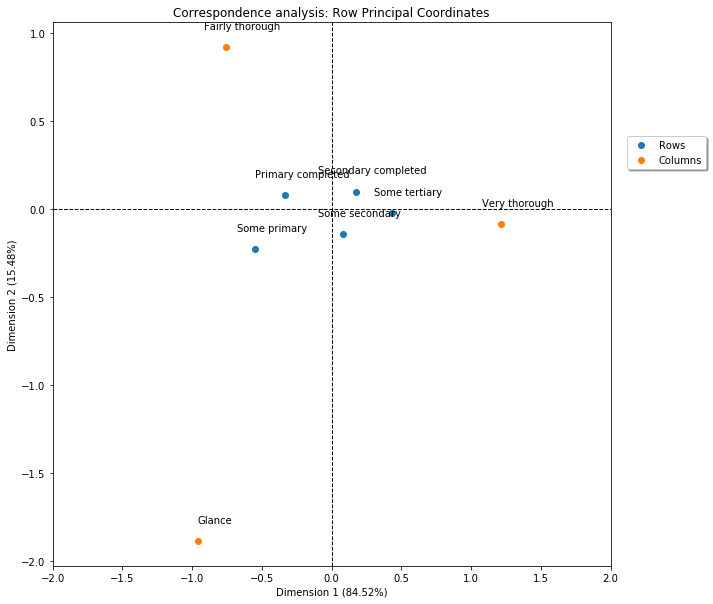

In [23]:
row_principal_coordinates(df_x = ca['pc_rows'],
                          df_y = ca['pc_columns'],
                          variance_explained = ca['variance_explained'])

In [0]:
row_principal_coordinates(df_x = ca['pc_rows'],
                          df_y = ca['pc_columns'],
                          variance_explained = ca['variance_explained'])

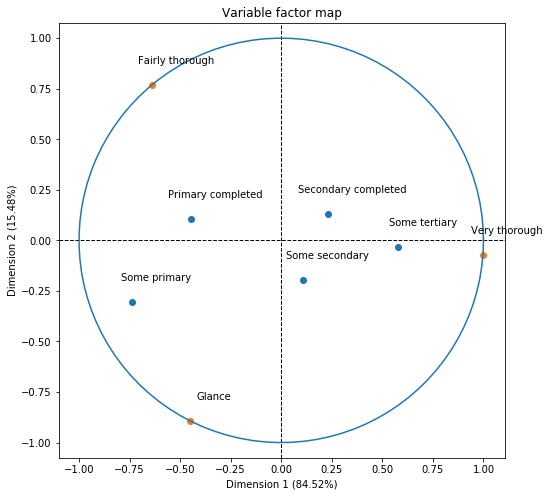

In [24]:
row_focus_coordinates(df_x = ca['pc_rows'],
                      df_y = ca['pc_columns'],
                      variance_explained = ca['variance_explained'])

# Test Library

In [2]:
!pip install --upgrade git+git://github.com/thomaspernet/Correspondence_analysis

  Cloning git://github.com/thomaspernet/Correspondence_analysis to /private/var/folders/n7/bb63f7vn6tn5cmm4nzxmrq7h0000gn/T/pip-req-build-loiexqie
  Stored in directory: /private/var/folders/n7/bb63f7vn6tn5cmm4nzxmrq7h0000gn/T/pip-ephem-wheel-cache-ndoz8cmi/wheels/b4/92/27/cc76ae992ebf6fbf4ebafa8ff993ba166eeed06ed1a8dfc5f1
Successfully built CorrespondenceAnalysisPy
  Found existing installation: CorrespondenceAnalysisPy 0.2
    Uninstalling CorrespondenceAnalysisPy-0.2:
      Successfully uninstalled CorrespondenceAnalysisPy-0.2


In [0]:
from CorrespondenceAnalysisPy.correspondence_analysis_computation import ca_compute
import pandas as pd

In [2]:
df = pd.DataFrame({
                  'education': ['Some primary', 'Primary completed', 
                            'Some secondary','Secondary completed',
                            'Some tertiary'],
                  'Glance': [5,18,19, 12, 3],
                  'Fairly thorough': [7,46,29,40,7],
                  'Very thorough': [2,20,39,49,16]})
df = df.set_index('education')
df.index

Index(['Some primary', 'Primary completed', 'Some secondary',
       'Secondary completed', 'Some tertiary'],
      dtype='object', name='education')

In [6]:
list(df)

['Glance', 'Fairly thorough', 'Very thorough']

In [3]:
ca = ca_compute.compute_ca(df)
ca_computed = ca.correspondance_analysis()
ca_computed

{'observed_proportion':                        Glance  Fairly thorough  Very thorough
 education                                                    
 Some primary         0.016026         0.022436       0.006410
 Primary completed    0.057692         0.147436       0.064103
 Some secondary       0.060897         0.092949       0.125000
 Secondary completed  0.038462         0.128205       0.157051
 Some tertiary        0.009615         0.022436       0.051282,
 'pc_rows':                         dim_1     dim_2
 education                              
 Some primary        -0.549335 -0.227136
 Primary completed   -0.333149  0.077685
 Some secondary       0.080531 -0.144593
 Secondary completed  0.173021  0.097480
 Some tertiary        0.430538 -0.023520,
 'pc_columns':                     dim_1     dim_2
 Glance          -0.958716 -1.885351
 Fairly thorough -0.760143  0.916944
 Very thorough    1.211947 -0.085880,
 'variance_explained': array([8.45162886e-01, 1.54837114e-01, 1.76897918e

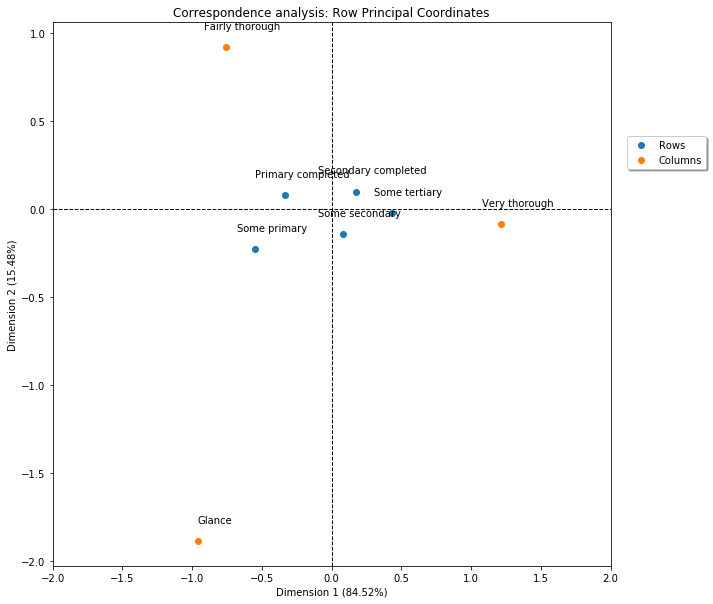

In [4]:
ca_compute.row_principal_coordinates(df_x = ca_computed['pc_rows'],
                                     df_y = ca_computed['pc_columns'],
                         variance_explained = ca_computed['variance_explained'])

In [0]:
temp = ca_compute.row_focus_coordinates(df_x = ca_computed['pc_rows'],
                      df_y = ca_computed['pc_columns'],
                      variance_explained = ca_computed['variance_explained'],
                                 export_data = True)

In [0]:
temp['saveimg']